# Comprehensive Contrastive Representation Distillation - CIFAR-100
## Full Analysis: SupCon vs SupCRD vs Balanced vs Hybrid

**Goal**: Comprehensive evaluation of contrastive distillation methods on CIFAR-100 with:
- α/β hyperparameter sweeps
- Temperature analysis
- Balanced force normalization
- Pull/push force dynamics
- Semantic similarity validation
- Hybrid loss optimization
- **Switchable architectures**: ConvNet vs ResNet-18

**Methods**:
- **Baseline SupCon**: Standard supervised contrastive learning
- **SupCRD**: Logit-weighted representation distillation (α, β tuning)
- **Balanced SupCRD**: Force-normalized variant
- **Hybrid**: Combined SupCon + SupCRD (λ tuning)

---
## Setup & Imports

In [1]:
import json
import os
import random
import warnings

import detectors
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

# Create directories
os.makedirs("plots", exist_ok=True)
os.makedirs("pth_models", exist_ok=True)
os.makedirs("json_results", exist_ok=True)
os.makedirs("json_results/training_logs", exist_ok=True)
print("✓ Created directories: plots/, pth_models/, json_results/")

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)
print(f"Random seed set to 42 for reproducibility")

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
warnings.filterwarnings("ignore", category=RuntimeWarning, module="threadpoolctl")

W1213 12:29:24.065000 3692 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


✓ Created directories: plots/, pth_models/, json_results/
Using device: cuda
Random seed set to 42 for reproducibility


---
## Architecture Selection & Hyperparameters

**KEY CONFIGURATION**: Set your architecture choice here!

In [2]:
# ============================================================
# ARCHITECTURE SELECTION (CHANGE HERE)
# ============================================================
TEACHER_ARCH = "resnet50"  # Options: "convnet" or "resnet50"
STUDENT_ARCH = "resnet18"  # Options: "convnet" or "resnet18"

# ============================================================
# TRAINING CONFIGURATION
# ============================================================
BATCH_SIZE = 128
LR = 1e-3

# Epoch settings (adjust based on architecture)
if TEACHER_ARCH == "resnet50" or TEACHER_ARCH == "resnet18":
    EPOCHS_TEACHER = 50
    EPOCHS_STUDENT = 50
    USE_LR_SCHEDULER = True
else:
    EPOCHS_TEACHER = 20  # ConvNet
    EPOCHS_STUDENT = 40
    USE_LR_SCHEDULER = False

# ============================================================
# CONTRASTIVE & DISTILLATION CONFIG
# ============================================================
TEMP = 0.07
ALPHA = 1.0
BETA = 10.0

# Sweep ranges (reduced for faster iteration)
ALPHA_SWEEP = [1.0, 2.0]  # Reduced from [1, 2, 3, 4, 5, 10, 50]
BETA_SWEEP = [1.0, 12.0]  # Reduced from [1, 10, 12, 20, 50]
TEMP_SWEEP = [0.05, 0.07]  # Reduced from [0.05, 0.07, 0.1, 0.15]
LAMBDA_SWEEP = [0.3, 0.5, 0.7, 0.9]

# ============================================================
# DATASET CONFIG (CIFAR-100)
# ============================================================
num_classes = 100

# CIFAR-100 superclass mapping (20 superclasses, 5 classes each)
cifar100_superclasses = [
    "aquatic_mammals",
    "fish",
    "flowers",
    "food_containers",
    "fruit_vegetables",
    "household_electrical",
    "household_furniture",
    "insects",
    "large_carnivores",
    "large_omnivores",
    "medium_mammals",
    "non-insect_invertebrates",
    "people",
    "reptiles",
    "small_mammals",
    "trees",
    "vehicles_1",
    "vehicles_2",
]

# Sample classes for visualization (not all 100)
sample_classes = list(range(20))

print(f"\n{'='*60}")
print(f"CONFIGURATION SUMMARY")
print(f"{'='*60}")
print(f"Teacher Architecture: {TEACHER_ARCH.upper()}")
print(f"Student Architecture: {STUDENT_ARCH.upper()}")
print(f"Dataset: CIFAR-100 ({num_classes} classes)")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LR}")
print(f"Teacher Epochs: {EPOCHS_TEACHER}")
print(f"Student Epochs: {EPOCHS_STUDENT}")
print(f"LR Scheduler: {USE_LR_SCHEDULER}")
print(f"Temperature: {TEMP}")
print(f"Training Mode: Multi-view (2 augmented views per sample)")
print(f"Alpha Sweep: {ALPHA_SWEEP}")
print(f"Beta Sweep: {BETA_SWEEP}")
print(f"Temp Sweep: {TEMP_SWEEP}")
print(f"{'='*60}\n")


class TwoViewTransform:
    """Create two augmented views of the same image"""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        view1 = self.base_transform(x)
        view2 = self.base_transform(x)
        return view1, view2


CONFIGURATION SUMMARY
Teacher Architecture: RESNET50
Student Architecture: RESNET18
Dataset: CIFAR-100 (100 classes)
Batch Size: 128
Learning Rate: 0.001
Teacher Epochs: 50
Student Epochs: 50
LR Scheduler: True
Temperature: 0.07
Training Mode: Multi-view (2 augmented views per sample)
Alpha Sweep: [1.0, 2.0]
Beta Sweep: [1.0, 12.0]
Temp Sweep: [0.05, 0.07]



---
## Data Loading with Augmentation

In [3]:
# CIFAR-100 mean and std
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

# Base training transform with augmentation
base_transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

# Multi-view wrapper (creates 2 augmented views per sample)
transform_train_multiview = TwoViewTransform(base_transform_train)

# Test transform (no augmentation, single view)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

train_set = torchvision.datasets.CIFAR100(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform_train_multiview  # Multi-view!
)
train_loader = DataLoader(
    train_set, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2,
    pin_memory=True
)

test_set = torchvision.datasets.CIFAR100(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform_test
)
test_loader = DataLoader(
    test_set, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True
)

print(f"Train samples: {len(train_set)}")
print(f"Test samples: {len(test_set)}")
print(f"Training mode: Multi-view (2 augmented views per sample)")
print(f"Augmentation: RandomCrop, HFlip, ColorJitter")

Train samples: 50000
Test samples: 10000
Training mode: Multi-view (2 augmented views per sample)
Augmentation: RandomCrop, HFlip, ColorJitter


---
## Model Architecture (Switchable)

Two architecture options:
1. **ConvNet**: Fast, 3-layer CNN (same as CIFAR-10)
2. **ResNet-18**: Deeper, more capacity, slower training

In [4]:
class ConvEncoder(nn.Module):
    """Shallow 3-layer ConvNet encoder"""

    def __init__(self, feature_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.flat_dim = 128 * 4 * 4
        self.fc = nn.Linear(self.flat_dim, feature_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


class ResNetEncoder(nn.Module):
    """ResNet encoder (adapted for CIFAR)"""

    def __init__(self, feature_dim=512, arch="resnet18"):  # Add arch parameter
        super().__init__()

        # Choose architecture
        if arch == "resnet18":
            resnet = models.resnet18(weights=None)
            base_dim = 512
        elif arch == "resnet50":
            resnet = models.resnet50(weights=None)
            base_dim = 2048  # ResNet50 has 2048-dim features!
        else:
            raise ValueError(f"Unknown ResNet arch: {arch}")

        # Replace first conv: kernel 7->3, stride 2->1, remove maxpool
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        # Skip maxpool for CIFAR (small images)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool

        # Project base_dim -> feature_dim if different
        if feature_dim != base_dim:
            self.projection = nn.Linear(base_dim, feature_dim)
        else:
            self.projection = nn.Identity()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.projection(x)
        return x


class ModelWrapper(nn.Module):
    """Wrapper with switchable encoder"""

    def __init__(self, num_classes=100, arch="convnet"):
        super().__init__()
        self.arch = arch

        if arch == "convnet":
            self.encoder = ConvEncoder(feature_dim=128)
            self.feature_dim = 128
        elif arch == "resnet18":
            self.encoder = ResNetEncoder(feature_dim=512, arch="resnet18")
            self.feature_dim = 512
        elif arch == "resnet50":
            self.encoder = ResNetEncoder(feature_dim=512, arch="resnet50")
            self.feature_dim = 512
        else:
            raise ValueError(f"Unknown architecture: {arch}")

        # Projector (for contrastive learning)
        self.projector = nn.Sequential(
            nn.Linear(self.feature_dim, 128), nn.ReLU(), nn.Linear(128, 64)
        )

        # Classifier
        self.classifier = nn.Linear(self.feature_dim, num_classes)

    def forward(self, x):
        feats = self.encoder(x)
        proj = self.projector(feats)
        logits = self.classifier(feats)
        return feats, proj, logits


# Test instantiation
test_teacher = ModelWrapper(num_classes=100, arch=TEACHER_ARCH).to(device)
test_student = ModelWrapper(num_classes=100, arch=STUDENT_ARCH).to(device)

print(f"✓ Model architectures defined")
print(f"  Teacher: {TEACHER_ARCH.upper()} ({test_teacher.feature_dim}-dim features)")
print(f"  Student: {STUDENT_ARCH.upper()} ({test_student.feature_dim}-dim features)")

# Count parameters
teacher_params = sum(p.numel() for p in test_teacher.parameters())
student_params = sum(p.numel() for p in test_student.parameters())
print(f"  Teacher params: {teacher_params:,}")
print(f"  Student params: {student_params:,}")

del test_teacher, test_student

✓ Model architectures defined
  Teacher: RESNET50 (512-dim features)
  Student: RESNET18 (512-dim features)
  Teacher params: 24,674,660
  Student params: 11,294,052


---
## Loss Functions

In [5]:
class SupConLoss(nn.Module):
    """Baseline Supervised Contrastive Loss"""

    def __init__(self, temperature=0.07):
        super().__init__()
        self.temp = temperature

    def forward(self, student_proj, labels):
        feats = F.normalize(student_proj, dim=1)
        sim_matrix = torch.matmul(feats, feats.T) / self.temp
        labels = labels.view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(feats.shape[0]).view(-1, 1).to(device),
            0,
        )
        mask = mask * logits_mask
        logits_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - logits_max.detach()
        exp_logits = torch.exp(sim_matrix) * logits_mask
        log_prob = sim_matrix - torch.log(exp_logits.sum(1, keepdim=True))
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-8)
        return -mean_log_prob_pos.mean()


class LogitWeightedSupCRDLoss(nn.Module):
    """SupCRD with α/β weighting"""

    def __init__(self, alpha=1.0, beta=1.0, temperature=0.07, eps=1e-8):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.tau = temperature
        self.eps = eps

    def forward(self, student_features, teacher_features, teacher_logits, labels):
        batch_size = student_features.shape[0]
        device = student_features.device

        s_norm = F.normalize(student_features, dim=1)
        t_norm = F.normalize(teacher_features, dim=1)

        sim_matrix = torch.matmul(s_norm, t_norm.T) / self.tau
        sim_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - sim_max.detach()
        exp_sim = torch.exp(sim_matrix)

        teacher_probs = F.softmax(teacher_logits, dim=1)
        labels = labels.view(-1, 1)
        mask_pos = torch.eq(labels, labels.T).float().to(device)
        mask_neg = 1.0 - mask_pos

        p_target = torch.gather(teacher_probs, 1, labels).view(-1)
        w_pull = self.alpha * p_target

        target_labels_expand = labels.view(1, -1).expand(batch_size, -1)
        p_negative_class = torch.gather(teacher_probs, 1, target_labels_expand)
        w_push = self.beta * (1.0 - p_negative_class)

        sum_pos_exp = (exp_sim * mask_pos).sum(dim=1)
        numerator_term = w_pull * sum_pos_exp
        weighted_neg_exp = (exp_sim * w_push * mask_neg).sum(dim=1)
        denominator_term = numerator_term + weighted_neg_exp

        loss = -torch.log((numerator_term + self.eps) / (denominator_term + self.eps))
        return loss.mean()


class HybridSupCRDLoss(nn.Module):
    """Hybrid: λ * SupCon + (1-λ) * SupCRD"""

    def __init__(self, alpha=1.0, beta=12.0, lambda_supcon=0.7, temperature=0.07):
        super().__init__()
        self.supcon_loss = SupConLoss(temperature=temperature)
        self.supcrd_loss = LogitWeightedSupCRDLoss(
            alpha=alpha, beta=beta, temperature=temperature
        )
        self.lambda_supcon = lambda_supcon
        self.register_buffer("supcon_scale", torch.tensor(1.0))
        self.register_buffer("supcrd_scale", torch.tensor(1.0))
        self.warmup_steps = 100
        self.step_count = 0

    def forward(self, student_proj, teacher_proj, teacher_logits, labels):
        loss_supcon = self.supcon_loss(student_proj, labels)
        loss_supcrd = self.supcrd_loss(
            student_proj, teacher_proj, teacher_logits, labels
        )
        if self.step_count < self.warmup_steps:
            self.step_count += 1
            with torch.no_grad():
                self.supcon_scale = 0.9 * self.supcon_scale + 0.1 * loss_supcon.detach()
                self.supcrd_scale = 0.9 * self.supcrd_scale + 0.1 * loss_supcrd.detach()
        loss_supcon_norm = loss_supcon / (self.supcon_scale + 1e-8)
        loss_supcrd_norm = loss_supcrd / (self.supcrd_scale + 1e-8)
        return (
            self.lambda_supcon * loss_supcon_norm
            + (1 - self.lambda_supcon) * loss_supcrd_norm
        )


print("✓ Loss functions defined")

✓ Loss functions defined


---
## Utility Functions

In [6]:
def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # If the model returns a tuple (main, aux1, aux2), take the first one (main)
            if isinstance(output, tuple):
                output = output[0] 
            
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
    return 100 * correct / total


def extract_features_and_labels(model, loader, device, max_samples=5000):
    """Extract features and labels for visualization."""
    model.eval()
    features_list = []
    labels_list = []
    count = 0
    
    with torch.no_grad():
        for images, labels in loader:
            if count >= max_samples:
                break
            images = images.to(device)
            
            # --- FIX: Handle different model output types ---
            output = model(images)
            if isinstance(output, tuple):
                # Old Wrapper: (features, projection, logits)
                # We usually visualize the projection 'proj' in students, 
                # but for the teacher backbone, 'feats' or 'proj' (if identity) works.
                _, proj, _ = output 
            else:
                # Standard timm (with fc=Identity): output IS the features
                proj = output
            # ------------------------------------------------
            
            features_list.append(proj.cpu().numpy())
            labels_list.append(labels.numpy())
            count += images.size(0)
    
    features = np.concatenate(features_list, axis=0)[:max_samples]
    labels = np.concatenate(labels_list, axis=0)[:max_samples]
    return features, labels


def visualize_latents(model, loader, device, title="", sample_classes=None, max_samples=5000):
    """Visualize latent space with t-SNE (sample subset for CIFAR-100)."""
    features, labels = extract_features_and_labels(model, loader, device, max_samples)
    
    # If sample_classes specified, only visualize those
    if sample_classes is not None:
        mask = np.isin(labels, sample_classes)
        features = features[mask]
        labels = labels[mask]
        print(f"  Visualizing {len(sample_classes)} classes, {len(features)} samples")
    
    print(f"  Running t-SNE on {len(features)} samples...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features)-1))
    embedded = tsne.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        mask = labels == label
        plt.scatter(embedded[mask, 0], embedded[mask, 1], 
                   label=f'Class {label}', alpha=0.6, s=20)
    
    plt.title(f't-SNE: {title}', fontsize=14, fontweight='bold')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    if len(unique_labels) <= 20:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    
    safe_title = title.replace(' ', '_').replace('/', '_')
    # Ensure plots directory exists
    os.makedirs('plots', exist_ok=True)
    plt.savefig(f'plots/tsne_{safe_title}.png', dpi=150, bbox_inches='tight')
    plt.show()


def compute_class_centroids(model, loader, device, num_classes=100):
    """Compute class centroids in feature space."""
    model.eval()
    centroids = {i: [] for i in range(num_classes)}
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            
            # --- FIX: Handle different model output types ---
            output = model(images)
            if isinstance(output, tuple):
                _, proj, _ = output
            else:
                proj = output
            # ------------------------------------------------
            
            proj_norm = F.normalize(proj, dim=1)
            
            for i in range(len(labels)):
                label = labels[i].item()
                centroids[label].append(proj_norm[i].cpu().numpy())
    
    # Average to get centroid
    for cls in centroids:
        if len(centroids[cls]) > 0:
            centroids[cls] = np.mean(centroids[cls], axis=0)
        else:
            # Fallback for empty classes (size depends on model output, typically 2048 for ResNet50)
            centroids[cls] = np.zeros(2048) 
    
    return centroids


def analyze_similarity(model, loader, device, class_pairs, title=""):
    """Analyze cosine similarity between specific class pairs."""
    centroids = compute_class_centroids(model, loader, device)
    
    print(f"\n{'='*60}")
    print(f"Semantic Similarity Analysis: {title}")
    print(f"{'='*60}")
    
    results = {}
    for cls1, cls2, desc in class_pairs:
        c1 = centroids[cls1]
        c2 = centroids[cls2]
        similarity = np.dot(c1, c2) / (np.linalg.norm(c1) * np.linalg.norm(c2) + 1e-8)
        results[f"{cls1}-{cls2}"] = similarity
        print(f"  {desc:30s}: {similarity:.3f}")
    
    print(f"{'='*60}\n")
    return results


def save_training_log(log_data, filename):
    """Save training log to JSON."""
    os.makedirs('json_results/training_logs', exist_ok=True)
    with open(f'json_results/training_logs/{filename}.json', 'w') as f:
        json.dump(log_data, f, indent=2)


def load_training_log(filename):
    """Load training log from JSON."""
    path = f'json_results/training_logs/{filename}.json'
    if os.path.exists(path):
        with open(path, 'r') as f:
            return json.load(f)
    return None

print("✓ Utility functions updated to handle both Tuple and Standard outputs")

✓ Utility functions updated to handle both Tuple and Standard outputs


---
## Training Functions

In [7]:
def train_teacher(
    teacher,
    train_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
    scheduler=None,
    log_name=None,
):
    """Train teacher with optional LR scheduling and multi-view support."""
    print(f"\n{'='*60}")
    print(f"TRAINING TEACHER MODEL ({epochs} epochs)")
    print(f"{'='*60}")

    training_log = {"epochs": [], "train_loss": [], "train_acc": []}
    teacher.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for batch_data in train_loader:
            # Handle both multi-view and single-view data
            if isinstance(batch_data[0], (tuple, list)):
                # Multi-view: ((view1, view2), labels)
                (view1, view2), labels = batch_data
                images = view1.to(device)  # Teacher only needs one view
            else:
                # Single-view (fallback): (images, labels)
                images, labels = batch_data
                images = images.to(device)

            labels = labels.to(device)
            _, _, logits = teacher(images)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        if scheduler is not None:
            scheduler.step()

        avg_loss = total_loss / len(train_loader)
        acc = 100.0 * correct / total
        lr = optimizer.param_groups[0]["lr"]
        print(
            f"Epoch {epoch+1:2d}/{epochs}: Loss={avg_loss:.3f} | Acc={acc:.1f}% | LR={lr:.6f}"
        )

        training_log["epochs"].append(epoch + 1)
        training_log["train_loss"].append(avg_loss)
        training_log["train_acc"].append(acc)

    if log_name:
        save_training_log(training_log, log_name)

    print(f"\n✓ Teacher training complete: {acc:.1f}% accuracy\n")
    return teacher, training_log


def train_student(
    teacher,
    student,
    train_loader,
    optimizer,
    criterion,
    device,
    epochs=20,
    label="",
    mode="supcrd",
    log_name=None,
):
    """Train student with multi-view support."""
    print(f"\n{'='*60}")
    print(f"TRAINING: {label} (mode={mode})")
    print(f"{'='*60}\n")

    teacher.eval()
    student.train()

    # Linear classifier on frozen features
    linear_classifier = nn.Linear(student.feature_dim, 100).to(device)
    classifier_opt = torch.optim.Adam(linear_classifier.parameters(), lr=LR)
    classifier_criterion = nn.CrossEntropyLoss()

    training_log = {"epochs": [], "contrastive_loss": [], "train_acc": []}

    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        for (view1, view2), labels_batch in train_loader:  # Multi-view input!
            # Create multiviewed batch: concatenate both views [2N, C, H, W]
            images = torch.cat([view1, view2], dim=0).to(device)
            labels_multi = torch.cat([labels_batch, labels_batch], dim=0).to(device)

            optimizer.zero_grad()

            # Teacher forward pass on multiviewed batch
            with torch.no_grad():
                teacher_features = teacher.encoder(images)
                teacher_proj = teacher.projector(teacher_features)
                teacher_logits = teacher.classifier(teacher_features)

            # Student forward pass on multiviewed batch
            student_features = student.encoder(images)
            student_proj = student.projector(student_features)

            # Compute contrastive loss on multiviewed batch (2N samples)
            if mode == "supcon":
                loss = criterion(student_proj, labels_multi)
            elif mode in ["supcrd", "hybrid", "balanced"]:
                loss = criterion(
                    student_proj, teacher_proj, teacher_logits, labels_multi
                )
            else:
                raise ValueError(f"Unknown mode: {mode}")

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Train linear classifier on frozen features (use view1 only)
            with torch.no_grad():
                frozen_features = student.encoder(view1.to(device))
            logits = linear_classifier(frozen_features)
            clf_loss = classifier_criterion(logits, labels_batch.to(device))
            classifier_opt.zero_grad()
            clf_loss.backward()
            classifier_opt.step()

            _, predicted = logits.max(1)
            total += labels_batch.size(0)  # Count original batch size (N)
            correct += predicted.eq(labels_batch.to(device)).sum().item()

        avg_loss = total_loss / len(train_loader)
        acc = 100.0 * correct / total
        print(
            f"  [{label}] Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Acc: {acc:.1f}%"
        )

        training_log["epochs"].append(epoch + 1)
        training_log["contrastive_loss"].append(avg_loss)
        training_log["train_acc"].append(acc)

    # Copy trained classifier to student
    student.classifier.load_state_dict(linear_classifier.state_dict())

    if log_name:
        save_training_log(training_log, log_name)

    print(f"\n✓ {label} training complete\n")
    return student, training_log


print("✓ Training functions defined")

✓ Training functions defined


---
## EXPERIMENT 1: Train Teacher

Creating model: resnet50_cifar100
Loading teacher from pth_models/teacher_resnet50_cifar100.pth
Load status: <All keys matched successfully>

Teacher Test Accuracy: 80.75%

📊 Visualizing teacher's latent space...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


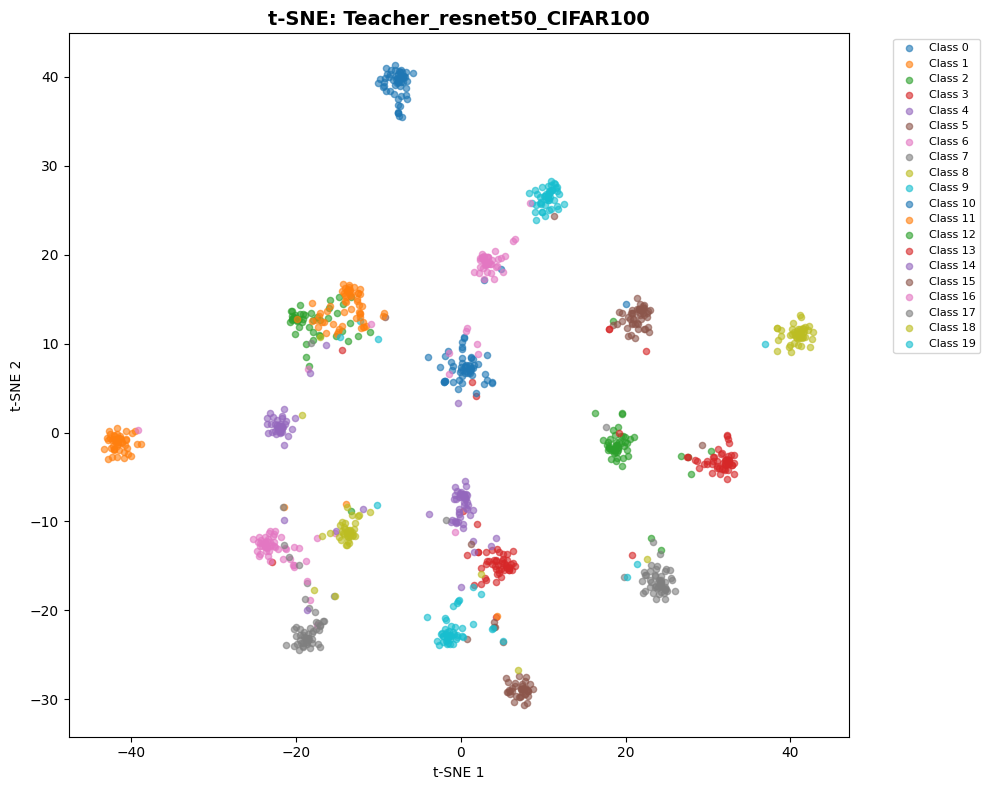

✓ Teacher visualization complete



In [8]:
# --- Configuration ---
FORCE_RETRAIN_TEACHER = False
# Ensure these variables are defined in your environment, or define them here:
# TEACHER_ARCH = "resnet50_cifar100" 
# num_classes = 100
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

teacher_model_path = f"pth_models/teacher_{TEACHER_ARCH}_cifar100.pth"

# --- 1. Model Initialization ---
print(f"Creating model: resnet50_cifar100")
teacher = timm.create_model("resnet50_cifar100", pretrained=False, num_classes=num_classes).to(device)

# --- 2. Robust Loading & Cleaning Logic ---
if os.path.exists(teacher_model_path) and not FORCE_RETRAIN_TEACHER:
    print(f"Loading teacher from {teacher_model_path}")
    
    # A. Load the raw checkpoint
    checkpoint = torch.load(teacher_model_path, map_location=device)
    
    # B. Rename keys (final_classifier -> fc) to match timm
    new_state_dict = {}
    for k, v in checkpoint.items():
        if k.startswith('final_classifier') or k.startswith('classifier'):
            new_key = k.replace('final_classifier', 'fc').replace('classifier', 'fc')
        else:
            new_key = k
        new_state_dict[new_key] = v
        
    # C. Load into the standard model
    # strict=False ignores the 'aux_classifier' keys in the file
    msg = teacher.load_state_dict(new_state_dict, strict=False)
    print(f"Load status: {msg}") 

    # D. CLEANUP: If there were unexpected keys (like aux heads), save the clean version
    if len(msg.unexpected_keys) > 0:
        print("Creating a clean checkpoint without auxiliary weights...")
        torch.save(teacher.state_dict(), teacher_model_path)
        print(f"✓ Overwrote {teacher_model_path} with the clean model structure.")

else:
    # --- 3. Training Logic (if needed) ---
    optimizer_teacher = torch.optim.Adam(teacher.parameters(), lr=LR)
    criterion_teacher = nn.CrossEntropyLoss()
    
    scheduler_teacher = None
    if USE_LR_SCHEDULER:
        scheduler_teacher = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_teacher, T_max=EPOCHS_TEACHER)

    teacher, teacher_log = train_teacher(
        teacher, train_loader, optimizer_teacher, criterion_teacher, device,
        epochs=EPOCHS_TEACHER, scheduler=scheduler_teacher,
        log_name=f"teacher_{TEACHER_ARCH}_cifar100",
    )
    torch.save(teacher.state_dict(), teacher_model_path)

# --- 4. Evaluation ---
acc_teacher = evaluate_model(teacher, test_loader, device)
print(f"\n{'='*50}")
print(f"Teacher Test Accuracy: {acc_teacher:.2f}%")
print(f"{'='*50}\n")

# --- 5. Visualization ---
print("📊 Visualizing teacher's latent space...")

# NOTE: Standard timm models output Logits (Class Scores) by default.
# If visualize_latents needs the 2048-dim embeddings, we temporarily
# remove the classifier to get the raw features.
original_fc = teacher.fc
teacher.fc = nn.Identity() # Temporarily replace classifier with identity

try:
    visualize_latents(
        teacher,
        test_loader,
        device,
        title=f"Teacher_{TEACHER_ARCH}_CIFAR100",
        sample_classes=sample_classes,
    )
    print("✓ Teacher visualization complete\n")
finally:
    teacher.fc = original_fc # Restore classifier just in case

---
## EXPERIMENT 2: Baseline SupCon

Loading baseline from pth_models/student_baseline_supcon_resnet18_cifar100.pth
  Train Acc (final): 90.81%

Baseline SupCon Test Accuracy: 69.08%

📊 Visualizing baseline's latent space...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


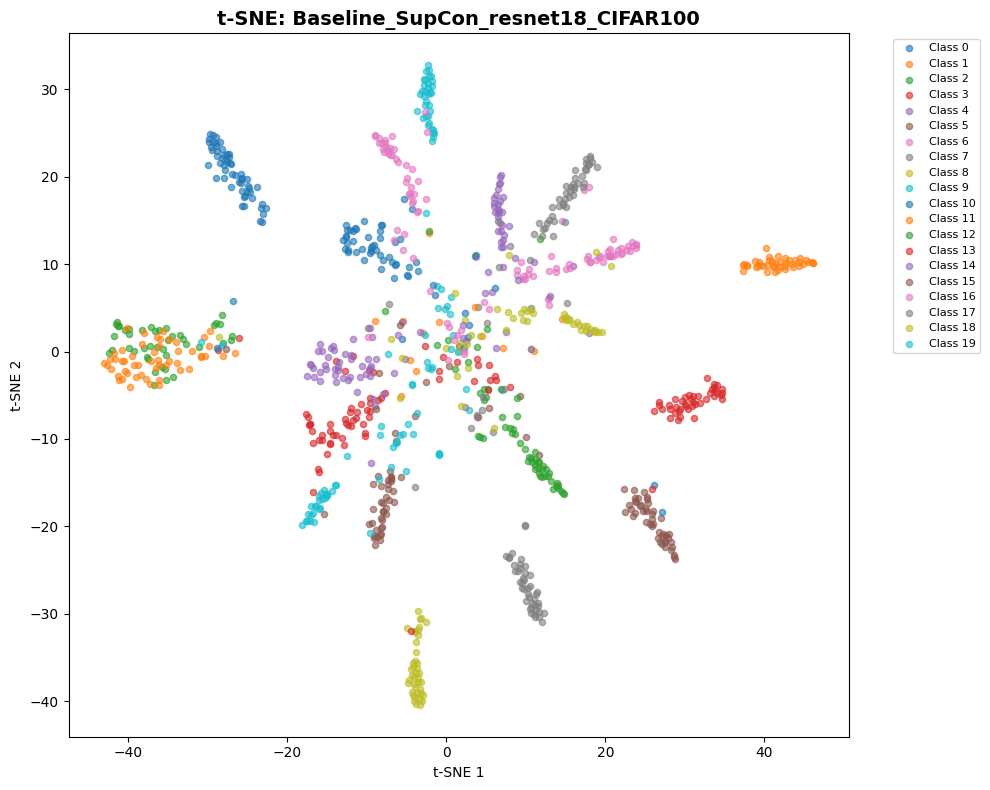

✓ Baseline visualization complete



In [9]:
FORCE_RETRAIN_BASELINE = False
baseline_model_path = f'pth_models/student_baseline_supcon_{STUDENT_ARCH}_cifar100.pth'

baseline_log = load_training_log(f'baseline_supcon_{STUDENT_ARCH}_cifar100')
if os.path.exists(baseline_model_path) and not FORCE_RETRAIN_BASELINE and baseline_log:
    print(f"Loading baseline from {baseline_model_path}")
    student_baseline = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
    student_baseline.load_state_dict(torch.load(baseline_model_path, map_location=device))
    print(f"  Train Acc (final): {baseline_log['train_acc'][-1]:.2f}%")
else:
    student_baseline = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
    optimizer_baseline = torch.optim.Adam(student_baseline.parameters(), lr=LR)
    criterion_baseline = SupConLoss(temperature=TEMP)
    student_baseline, baseline_log = train_student(
        teacher, student_baseline, train_loader, optimizer_baseline,
        criterion_baseline, device, epochs=EPOCHS_STUDENT,
        label="Baseline_SupCon", mode='supcon', 
        log_name=f'baseline_supcon_{STUDENT_ARCH}_cifar100'
    )
    torch.save(student_baseline.state_dict(), baseline_model_path)

acc_baseline = evaluate_model(student_baseline, test_loader, device)
print(f"\n{'='*50}")
print(f"Baseline SupCon Test Accuracy: {acc_baseline:.2f}%")
print(f"{'='*50}\n")

# Visualize baseline's latent space
print("📊 Visualizing baseline's latent space...")
visualize_latents(
    student_baseline, 
    test_loader, 
    device, 
    title=f"Baseline_SupCon_{STUDENT_ARCH}_CIFAR100",
    sample_classes=sample_classes
)
print("✓ Baseline visualization complete\n")

---
## EXPERIMENT 3: Alpha Sweep (β=1 fixed)

Loading alpha_1.0_beta_1.0 from cache
α=1.0: Train=90.5%, Test=69.7%

📊 Visualizing α=1.0...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


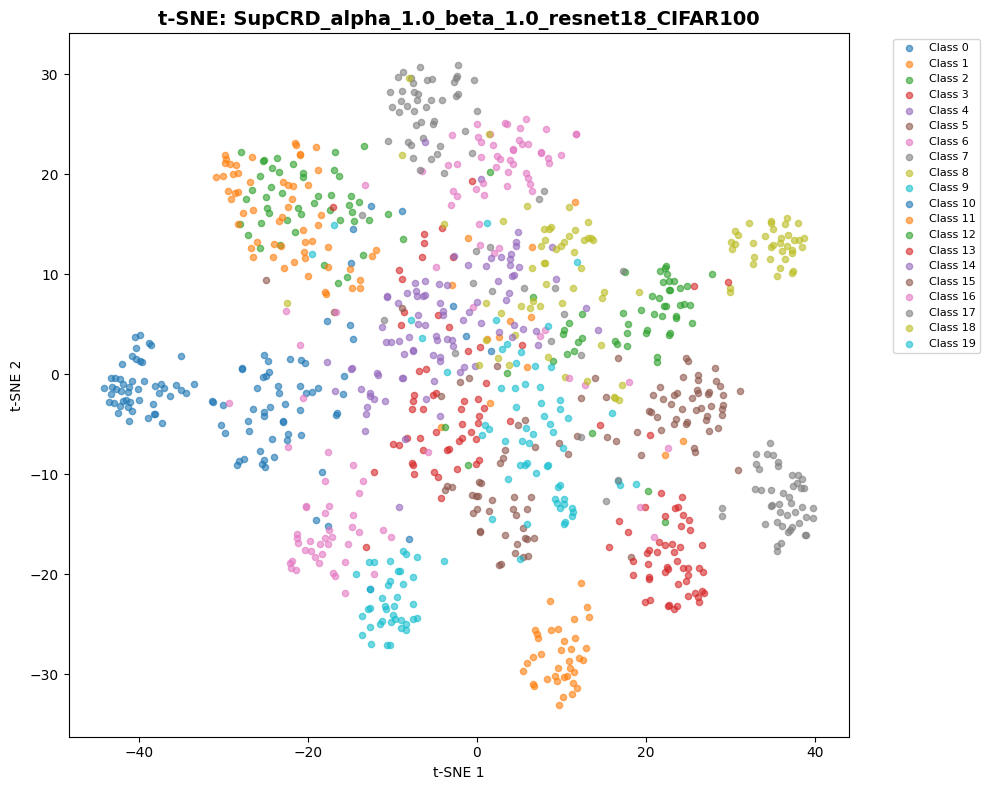

✓ α=1.0 visualization complete

Loading alpha_2.0_beta_1.0 from cache
α=2.0: Train=88.8%, Test=70.1%

📊 Visualizing α=2.0...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


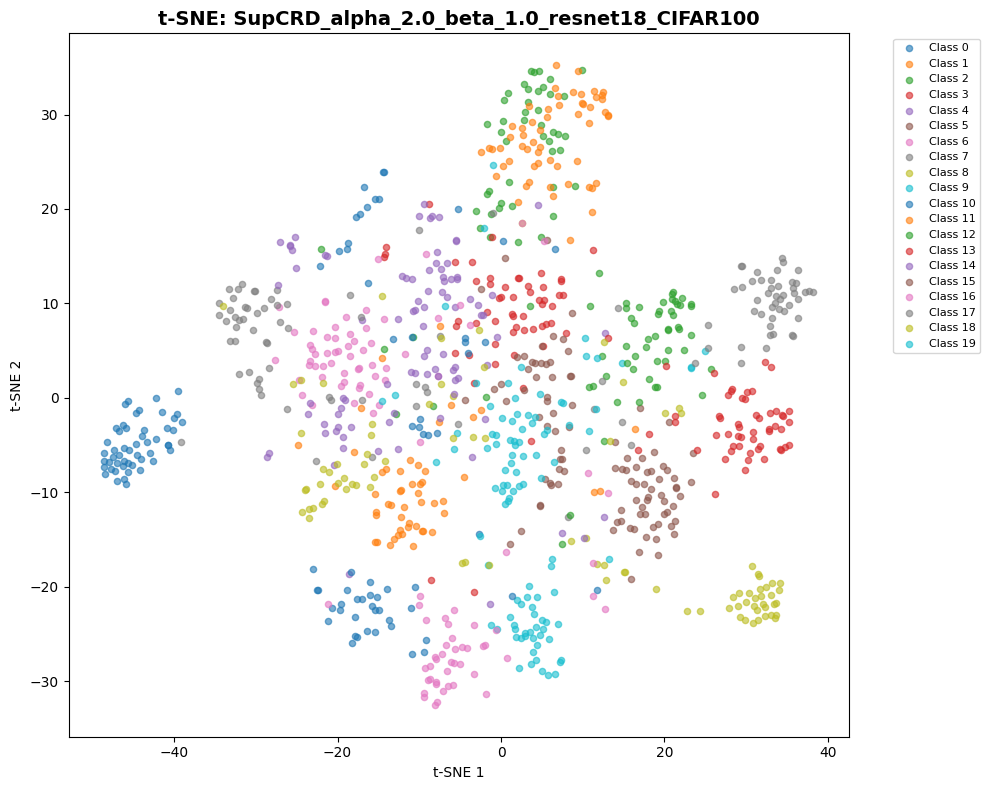

✓ α=2.0 visualization complete


ALPHA SWEEP SUMMARY (β=1.0, τ=0.07)
α=  1.0: Test=69.74% (Δ=+0.66%)
α=  2.0: Test=70.09% (Δ=+1.01%)



In [10]:
FORCE_RETRAIN_ALPHA_SWEEP = False

alpha_results = {}
for alpha_val in ALPHA_SWEEP:
    exp_name = f'alpha_{alpha_val}_beta_1.0'
    model_path = f'pth_models/student_{exp_name}_{STUDENT_ARCH}_cifar100.pth'
    
    log = load_training_log(f'{exp_name}_{STUDENT_ARCH}_cifar100')
    if os.path.exists(model_path) and not FORCE_RETRAIN_ALPHA_SWEEP and log:
        print(f"Loading {exp_name} from cache")
        student = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
        student.load_state_dict(torch.load(model_path, map_location=device))
        train_acc = log['train_acc'][-1]
    else:
        student = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=LR)
        criterion = LogitWeightedSupCRDLoss(alpha=alpha_val, beta=1.0, temperature=TEMP)
        student, log = train_student(
            teacher, student, train_loader, optimizer, criterion, device,
            epochs=EPOCHS_STUDENT, label=f'SupCRD_α={alpha_val}', mode='supcrd',
            log_name=f'{exp_name}_{STUDENT_ARCH}_cifar100'
        )
        torch.save(student.state_dict(), model_path)
        train_acc = log['train_acc'][-1]
    
    test_acc = evaluate_model(student, test_loader, device)
    alpha_results[alpha_val] = {'train': train_acc, 'test': test_acc}
    print(f"α={alpha_val}: Train={train_acc:.1f}%, Test={test_acc:.1f}%\n")
    
    # Visualize this alpha config
    print(f"📊 Visualizing α={alpha_val}...")
    visualize_latents(student, test_loader, device,
        title=f"SupCRD_alpha_{alpha_val}_beta_1.0_{STUDENT_ARCH}_CIFAR100",
        sample_classes=sample_classes)
    print(f"✓ α={alpha_val} visualization complete\n")

# Summary
print(f"\n{'='*60}")
print(f"ALPHA SWEEP SUMMARY (β=1.0, τ={TEMP})")
print(f"{'='*60}")
for alpha_val, res in alpha_results.items():
    delta = res['test'] - acc_baseline
    print(f"α={alpha_val:5.1f}: Test={res['test']:5.2f}% (Δ={delta:+.2f}%)")
print(f"{'='*60}\n")



---
## EXPERIMENT 4: Beta Sweep (α=1 fixed)

Loading alpha_1.0_beta_1.0 from cache
β=1.0: Train=90.5%, Test=69.7%

📊 Visualizing β=1.0...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


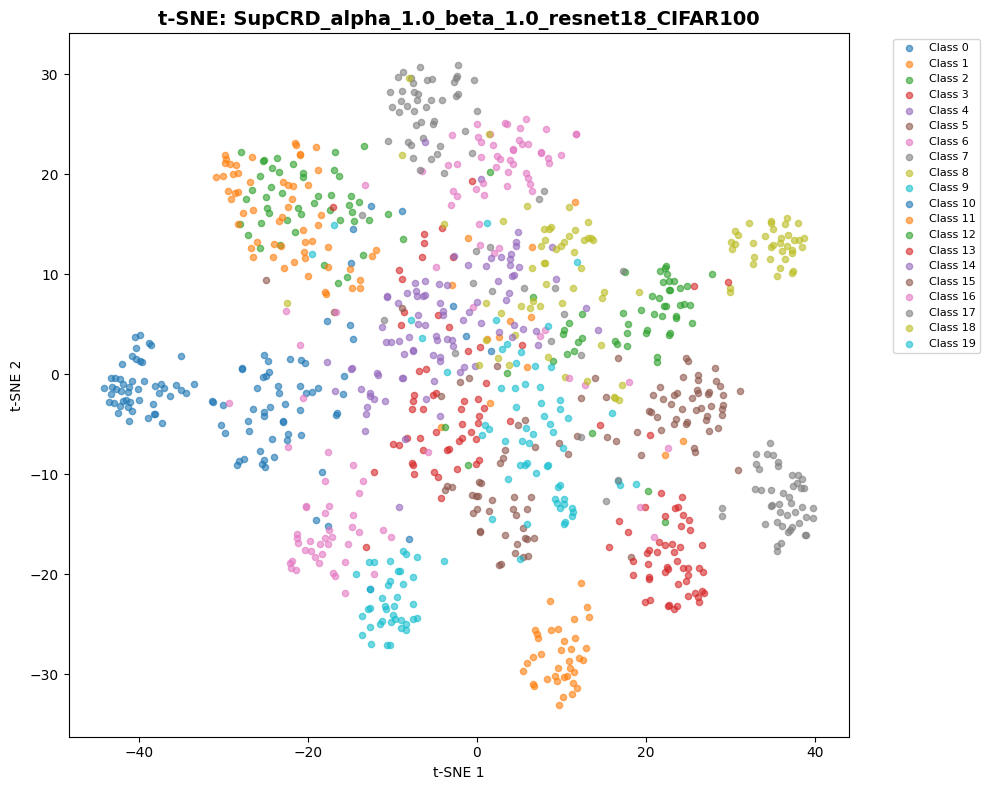

✓ β=1.0 visualization complete

Loading alpha_1.0_beta_12.0 from cache
β=12.0: Train=93.3%, Test=71.4%

📊 Visualizing β=12.0...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


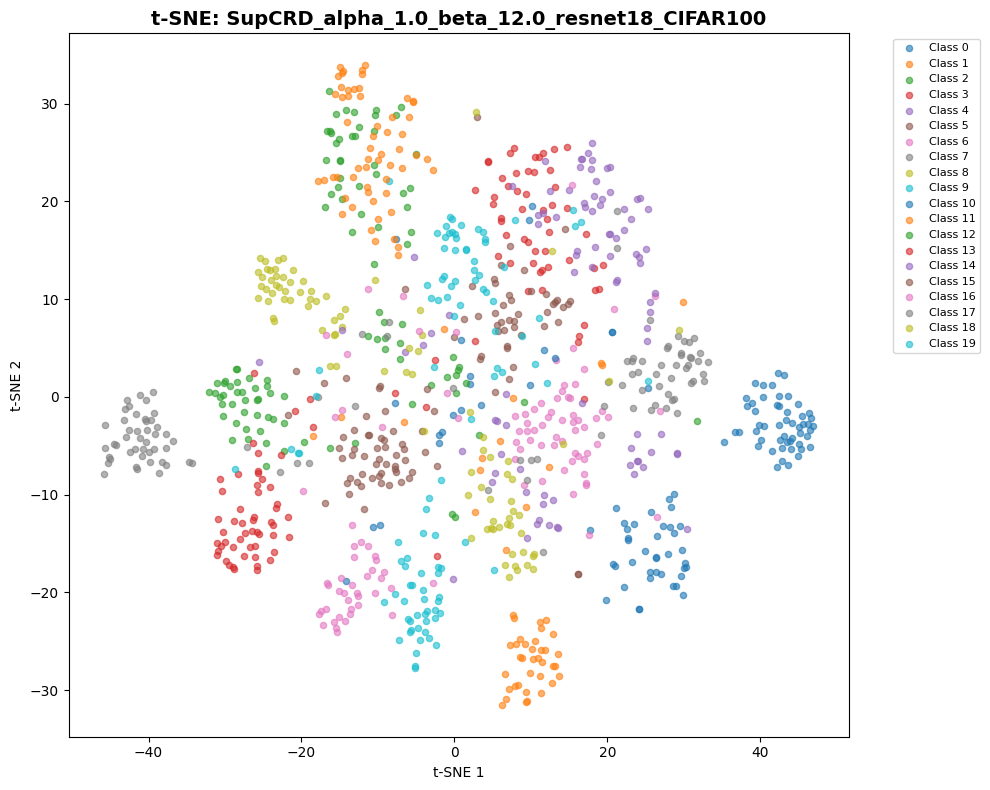

✓ β=12.0 visualization complete


BETA SWEEP SUMMARY (α=1.0, τ=0.07)
β=  1.0: Test=69.74% (Δ=+0.66%)
β= 12.0: Test=71.41% (Δ=+2.33%)



In [11]:
FORCE_RETRAIN_BETA_SWEEP = False

beta_results = {}
for beta_val in BETA_SWEEP:
    exp_name = f'alpha_1.0_beta_{beta_val}'
    model_path = f'pth_models/student_{exp_name}_{STUDENT_ARCH}_cifar100.pth'
    
    log = load_training_log(f'{exp_name}_{STUDENT_ARCH}_cifar100')
    if os.path.exists(model_path) and not FORCE_RETRAIN_BETA_SWEEP and log:
        print(f"Loading {exp_name} from cache")
        student = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
        student.load_state_dict(torch.load(model_path, map_location=device))
        train_acc = log['train_acc'][-1]
    else:
        student = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=LR)
        criterion = LogitWeightedSupCRDLoss(alpha=1.0, beta=beta_val, temperature=TEMP)
        student, log = train_student(
            teacher, student, train_loader, optimizer, criterion, device,
            epochs=EPOCHS_STUDENT, label=f'SupCRD_β={beta_val}', mode='supcrd',
            log_name=f'{exp_name}_{STUDENT_ARCH}_cifar100'
        )
        torch.save(student.state_dict(), model_path)
        train_acc = log['train_acc'][-1]
    
    test_acc = evaluate_model(student, test_loader, device)
    beta_results[beta_val] = {'train': train_acc, 'test': test_acc}
    print(f"β={beta_val}: Train={train_acc:.1f}%, Test={test_acc:.1f}%\n")
    
    # Visualize this beta config
    print(f"📊 Visualizing β={beta_val}...")
    visualize_latents(student, test_loader, device,
        title=f"SupCRD_alpha_1.0_beta_{beta_val}_{STUDENT_ARCH}_CIFAR100",
        sample_classes=sample_classes)
    print(f"✓ β={beta_val} visualization complete\n")

# Summary
print(f"\n{'='*60}")
print(f"BETA SWEEP SUMMARY (α=1.0, τ={TEMP})")
print(f"{'='*60}")
for beta_val, res in beta_results.items():
    delta = res['test'] - acc_baseline
    print(f"β={beta_val:5.1f}: Test={res['test']:5.2f}% (Δ={delta:+.2f}%)")
print(f"{'='*60}\n")

---
## EXPERIMENT 5: Temperature Sweep (α=1, β=12)

Loading alpha_1.0_beta_12.0_temp_0.05 from cache
τ=0.05: Train=89.6%, Test=70.1%

📊 Visualizing τ=0.05...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


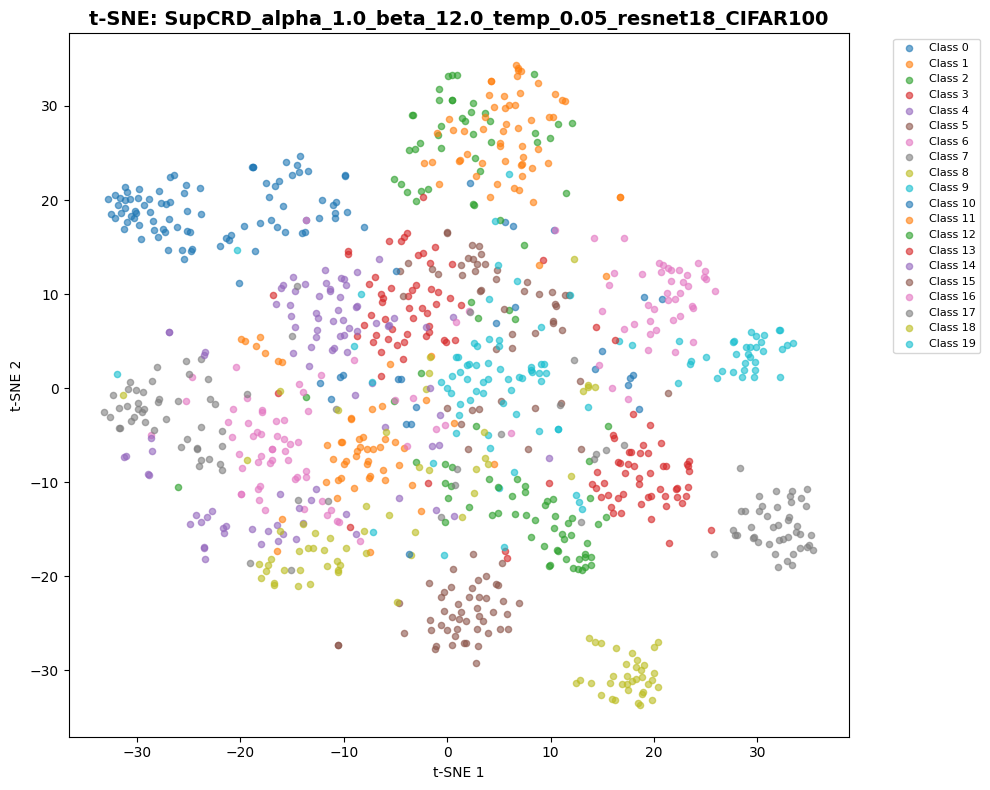

✓ τ=0.05 visualization complete

Loading alpha_1.0_beta_12.0_temp_0.07 from cache
τ=0.07: Train=93.5%, Test=71.3%

📊 Visualizing τ=0.07...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


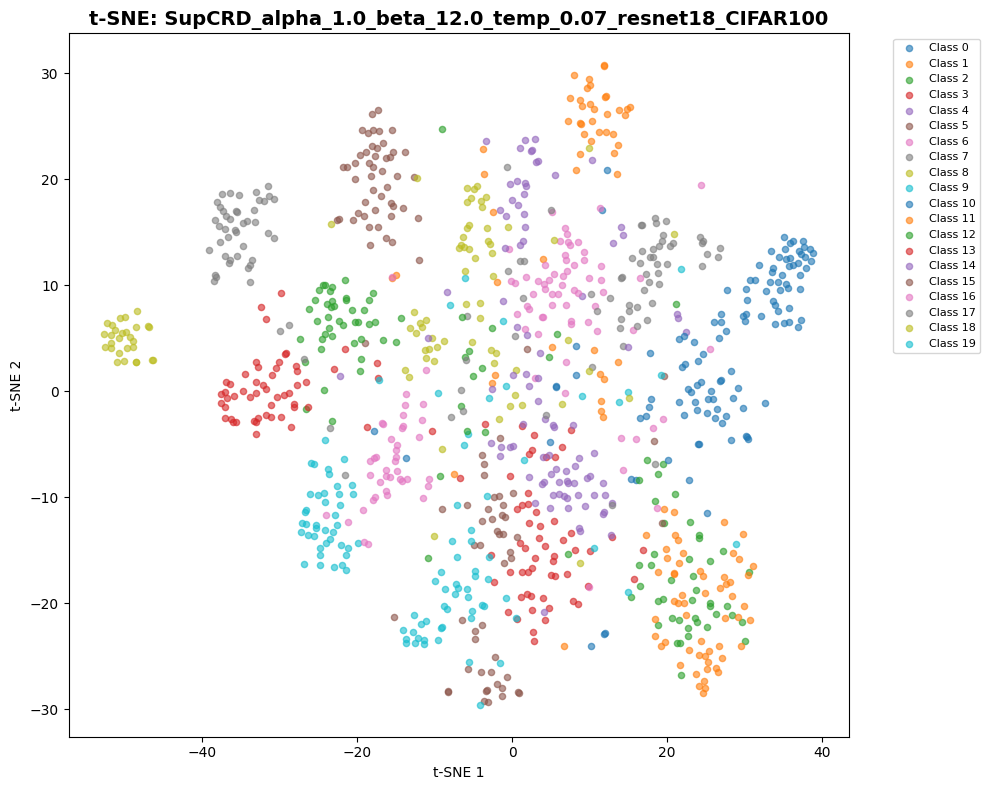

✓ τ=0.07 visualization complete


TEMPERATURE SWEEP SUMMARY (α=1.0, β=12.0)
τ= 0.05: Test=70.06% (Δ=+0.98%)
τ= 0.07: Test=71.30% (Δ=+2.22%)



In [12]:
FORCE_RETRAIN_TEMP_SWEEP = False

temp_results = {}
for temp_val in TEMP_SWEEP:
    exp_name = f'alpha_1.0_beta_12.0_temp_{temp_val}'
    model_path = f'pth_models/student_{exp_name}_{STUDENT_ARCH}_cifar100.pth'
    
    log = load_training_log(f'{exp_name}_{STUDENT_ARCH}_cifar100')
    if os.path.exists(model_path) and not FORCE_RETRAIN_TEMP_SWEEP and log:
        print(f"Loading {exp_name} from cache")
        student = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
        student.load_state_dict(torch.load(model_path, map_location=device))
        train_acc = log['train_acc'][-1]
    else:
        student = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=LR)
        criterion = LogitWeightedSupCRDLoss(alpha=1.0, beta=12.0, temperature=temp_val)
        student, log = train_student(
            teacher, student, train_loader, optimizer, criterion, device,
            epochs=EPOCHS_STUDENT, label=f'SupCRD_τ={temp_val}', mode='supcrd',
            log_name=f'{exp_name}_{STUDENT_ARCH}_cifar100'
        )
        torch.save(student.state_dict(), model_path)
        train_acc = log['train_acc'][-1]
    
    test_acc = evaluate_model(student, test_loader, device)
    temp_results[temp_val] = {'train': train_acc, 'test': test_acc}
    print(f"τ={temp_val}: Train={train_acc:.1f}%, Test={test_acc:.1f}%\n")
    
    # Visualize this temperature config
    print(f"📊 Visualizing τ={temp_val}...")
    visualize_latents(student, test_loader, device,
        title=f"SupCRD_alpha_1.0_beta_12.0_temp_{temp_val}_{STUDENT_ARCH}_CIFAR100",
        sample_classes=sample_classes)
    print(f"✓ τ={temp_val} visualization complete\n")

# Summary
print(f"\n{'='*60}")
print(f"TEMPERATURE SWEEP SUMMARY (α=1.0, β=12.0)")
print(f"{'='*60}")
for temp_val, res in temp_results.items():
    delta = res['test'] - acc_baseline
    print(f"τ={temp_val:5.2f}: Test={res['test']:5.2f}% (Δ={delta:+.2f}%)")
print(f"{'='*60}\n")

---
## EXPERIMENT 6: Semantic Similarity Analysis

Compare semantic structure for selected class pairs

In [13]:
# Define representative class pairs for CIFAR-100
# Format: (class1_idx, class2_idx, description)
class_pairs = [
    (3, 42, "baby-boy (similar)"),
    (3, 99, "baby-worm (dissimilar)"),
    (4, 55, "bear-otter (similar mammals)"),
    (4, 8, "bear-bicycle (dissimilar)"),
    (11, 35, "boy-girl (similar)"),
    (11, 90, "boy-tulip (dissimilar)"),
]

print("\n" + "="*80)
print("SEMANTIC SIMILARITY COMPARISON")
print("="*80)

# Analyze baseline
baseline_sim = analyze_similarity(
    student_baseline, test_loader, device, 
    class_pairs, title="Baseline SupCon"
)

# Analyze best SupCRD (choose best from sweeps)
best_alpha = max(alpha_results.items(), key=lambda x: x[1]['test'])[0]
best_supcrd_path = f'pth_models/student_alpha_{best_alpha}_beta_1.0_{STUDENT_ARCH}_cifar100.pth'
if os.path.exists(best_supcrd_path):
    student_best = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(device)
    student_best.load_state_dict(torch.load(best_supcrd_path, map_location=device))
    best_sim = analyze_similarity(
        student_best, test_loader, device,
        class_pairs, title=f"SupCRD (α={best_alpha}, β=1)"
    )


SEMANTIC SIMILARITY COMPARISON

Semantic Similarity Analysis: Baseline SupCon
  baby-boy (similar)            : 0.651
  baby-worm (dissimilar)        : 0.423
  bear-otter (similar mammals)  : 0.929
  bear-bicycle (dissimilar)     : 0.323
  boy-girl (similar)            : 0.964
  boy-tulip (dissimilar)        : 0.234


Semantic Similarity Analysis: SupCRD (α=2.0, β=1)
  baby-boy (similar)            : 0.105
  baby-worm (dissimilar)        : 0.062
  bear-otter (similar mammals)  : 0.701
  bear-bicycle (dissimilar)     : -0.128
  boy-girl (similar)            : 0.889
  boy-tulip (dissimilar)        : -0.143



---
## EXPERIMENT 7: Hybrid Loss

Loading hybrid_lambda_0.3 from cache
λ=0.3: Train=98.6%, Test=73.7%

📊 Visualizing λ=0.3...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


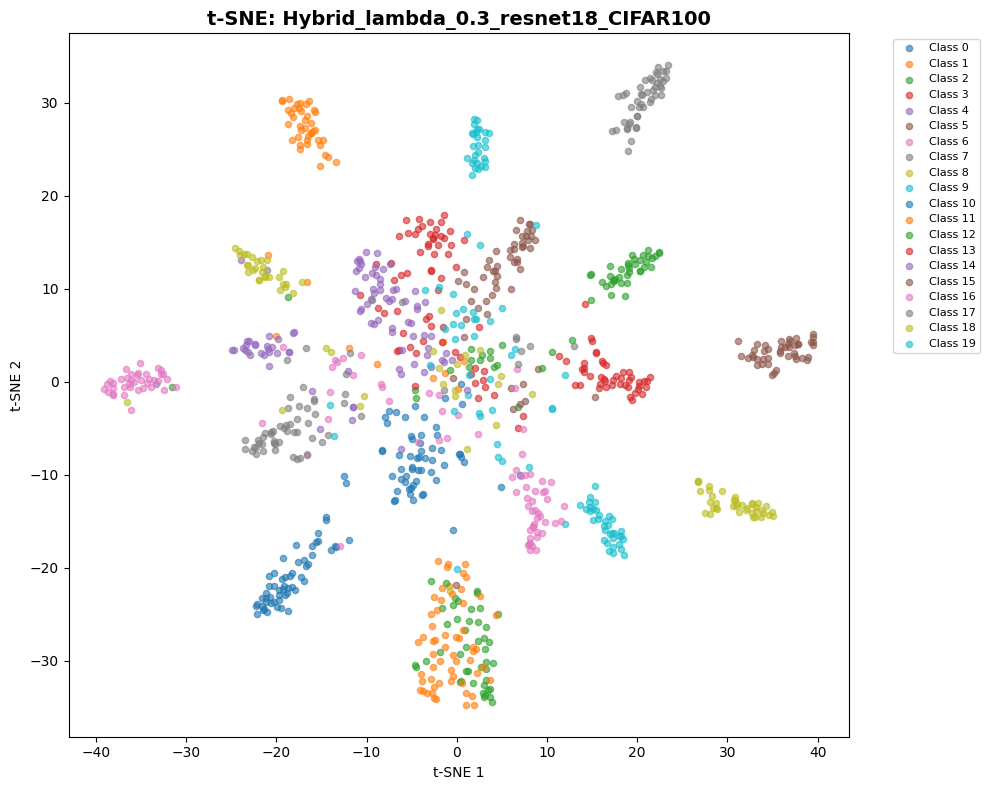

✓ λ=0.3 visualization complete

Loading hybrid_lambda_0.5 from cache
λ=0.5: Train=98.6%, Test=72.0%

📊 Visualizing λ=0.5...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


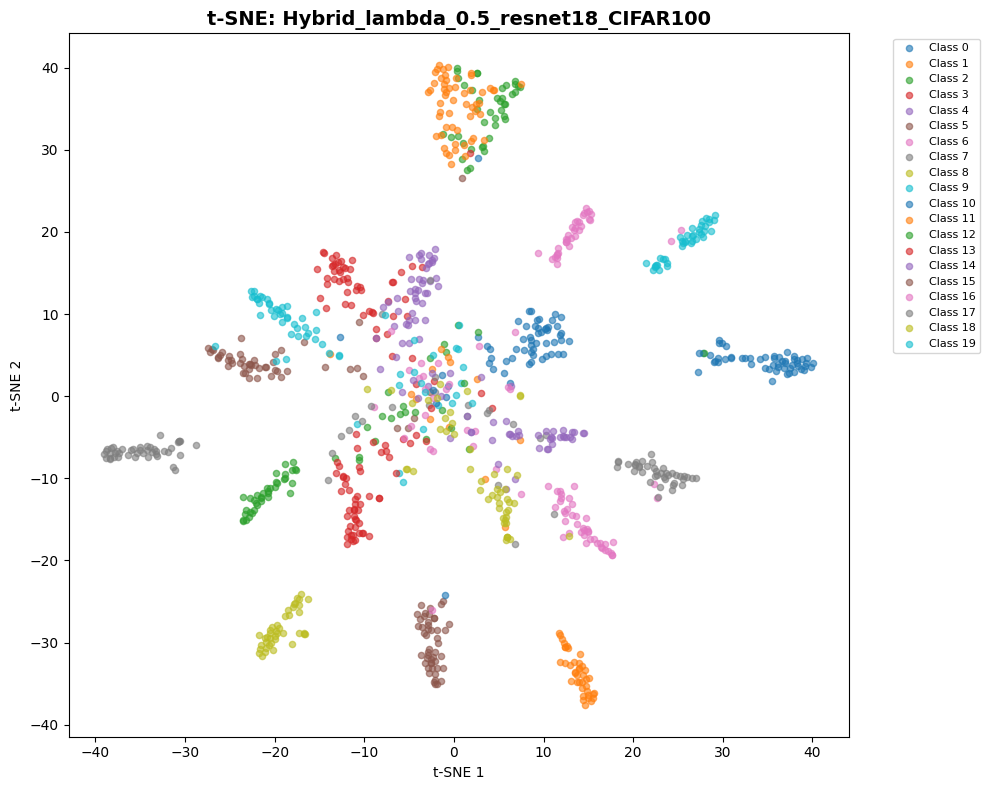

✓ λ=0.5 visualization complete

Loading hybrid_lambda_0.7 from cache
λ=0.7: Train=97.2%, Test=71.2%

📊 Visualizing λ=0.7...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


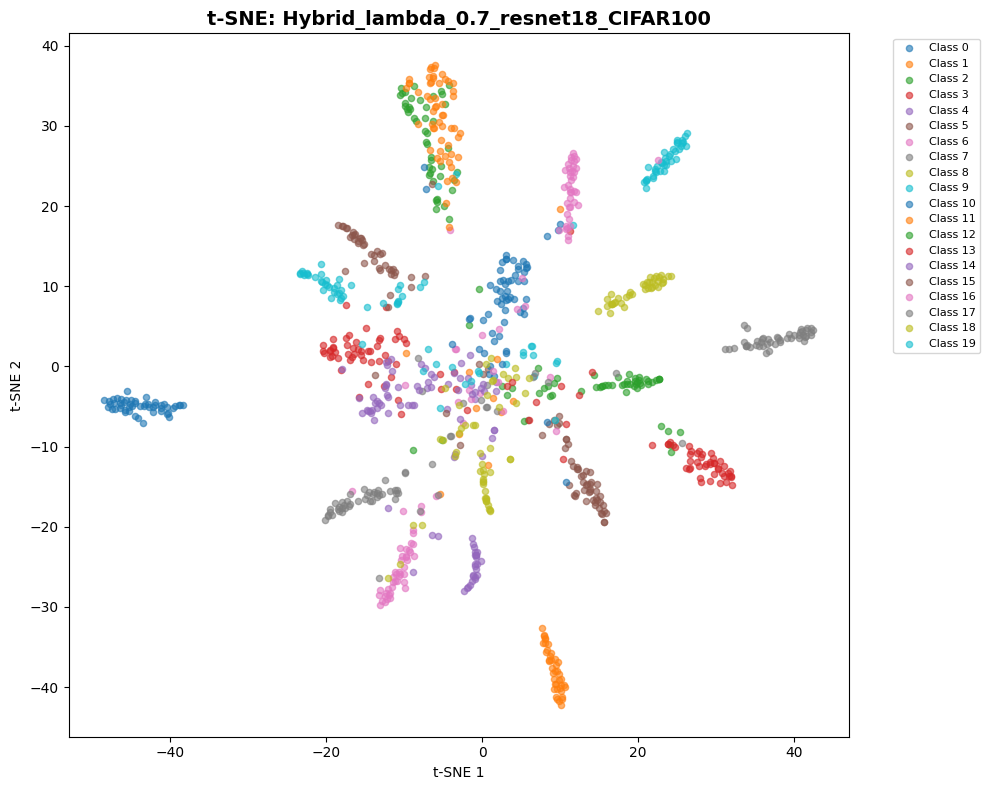

✓ λ=0.7 visualization complete

Loading hybrid_lambda_0.9 from cache
λ=0.9: Train=94.3%, Test=70.0%

📊 Visualizing λ=0.9...
  Visualizing 20 classes, 1025 samples
  Running t-SNE on 1025 samples...


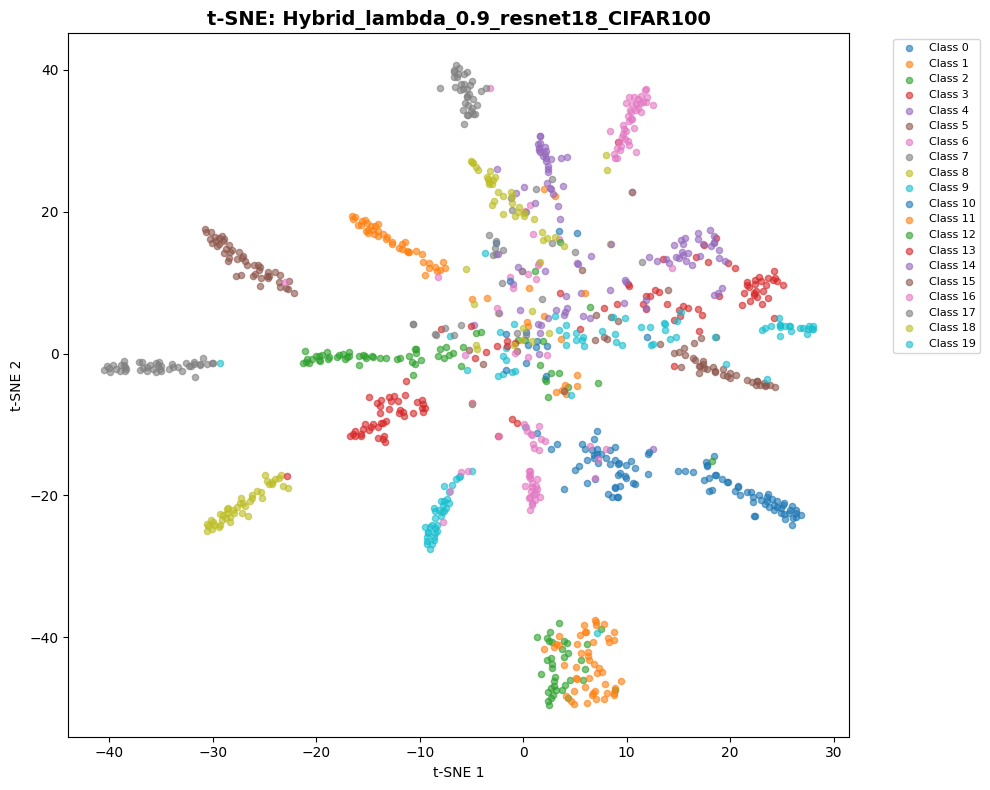

✓ λ=0.9 visualization complete


HYBRID LOSS SUMMARY (α=1.0, β=12.0, τ=0.07)
λ= 0.30: Test=73.65% (Δ=+4.57%)
λ= 0.50: Test=72.01% (Δ=+2.93%)
λ= 0.70: Test=71.25% (Δ=+2.17%)
λ= 0.90: Test=69.98% (Δ=+0.90%)



In [14]:
FORCE_RETRAIN_HYBRID = False
RUN_HYBRID_EXPERIMENTS = True  # Set to True to run hybrid experiments

if RUN_HYBRID_EXPERIMENTS:
    hybrid_results = {}
    for lambda_val in LAMBDA_SWEEP:
        exp_name = f"hybrid_lambda_{lambda_val}"
        model_path = f"pth_models/student_{exp_name}_{STUDENT_ARCH}_cifar100.pth"

        log = load_training_log(f"{exp_name}_{STUDENT_ARCH}_cifar100")
        if os.path.exists(model_path) and not FORCE_RETRAIN_HYBRID and log:
            print(f"Loading {exp_name} from cache")
            student = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(
                device
            )
            student.load_state_dict(torch.load(model_path, map_location=device))
            train_acc = log["train_acc"][-1]
        else:
            student = ModelWrapper(num_classes=num_classes, arch=STUDENT_ARCH).to(
                device
            )
            optimizer = torch.optim.Adam(student.parameters(), lr=LR)
            criterion = HybridSupCRDLoss(
                alpha=1.0, beta=12.0, lambda_supcon=lambda_val, temperature=TEMP
            )
            student, log = train_student(
                teacher,
                student,
                train_loader,
                optimizer,
                criterion,
                device,
                epochs=EPOCHS_STUDENT,
                label=f"Hybrid_λ={lambda_val}",
                mode="hybrid",
                log_name=f"{exp_name}_{STUDENT_ARCH}_cifar100",
            )
            torch.save(student.state_dict(), model_path)
            train_acc = log["train_acc"][-1]

        test_acc = evaluate_model(student, test_loader, device)
        hybrid_results[lambda_val] = {"train": train_acc, "test": test_acc}
        print(f"λ={lambda_val}: Train={train_acc:.1f}%, Test={test_acc:.1f}%\n")

        # Visualize this hybrid config
        print(f"📊 Visualizing λ={lambda_val}...")
        visualize_latents(
            student,
            test_loader,
            device,
            title=f"Hybrid_lambda_{lambda_val}_{STUDENT_ARCH}_CIFAR100",
            sample_classes=sample_classes,
        )
        print(f"✓ λ={lambda_val} visualization complete\n")

    # Summary
    print(f"\n{'='*60}")
    print(f"HYBRID LOSS SUMMARY (α=1.0, β=12.0, τ={TEMP})")
    print(f"{'='*60}")
    for lambda_val, res in hybrid_results.items():
        delta = res["test"] - acc_baseline
        print(f"λ={lambda_val:5.2f}: Test={res['test']:5.2f}% (Δ={delta:+.2f}%)")
    print(f"{'='*60}\n")
else:
    print("Skipping hybrid experiments (RUN_HYBRID_EXPERIMENTS=False)")

---
## Final Summary & Export Results

In [15]:
# Compile comprehensive results
comprehensive_results = {
    'config': {
        'dataset': 'CIFAR-100',
        'teacher_arch': TEACHER_ARCH,
        'student_arch': STUDENT_ARCH,
        'epochs_teacher': EPOCHS_TEACHER,
        'epochs_student': EPOCHS_STUDENT,
        'batch_size': BATCH_SIZE,
        'lr': LR,
        'temperature': TEMP,
    },
    'teacher': {
        'test_acc': acc_teacher,
    },
    'baseline_supcon': {
        'test_acc': acc_baseline,
    },
    'alpha_sweep': alpha_results,
    'beta_sweep': beta_results,
    'temp_sweep': temp_results,
}

if RUN_HYBRID_EXPERIMENTS:
    comprehensive_results['hybrid_sweep'] = hybrid_results

# Save to JSON
results_path = f'json_results/comprehensive_results_{STUDENT_ARCH}_cifar100.json'
with open(results_path, 'w') as f:
    json.dump(comprehensive_results, f, indent=2)

print(f"\n{'='*70}")
print(f"FINAL SUMMARY - CIFAR-100")
print(f"{'='*70}")
print(f"Architecture: Teacher={TEACHER_ARCH.upper()}, Student={STUDENT_ARCH.upper()}")
print(f"Teacher:        {acc_teacher:.2f}%")
print(f"Baseline:       {acc_baseline:.2f}%")
print(f"\nBest α config:  {max(alpha_results.items(), key=lambda x: x[1]['test'])[0]} → {max(alpha_results.values(), key=lambda x: x['test'])['test']:.2f}%")
print(f"Best β config:  {max(beta_results.items(), key=lambda x: x[1]['test'])[0]} → {max(beta_results.values(), key=lambda x: x['test'])['test']:.2f}%")
print(f"Best τ config:  {max(temp_results.items(), key=lambda x: x[1]['test'])[0]} → {max(temp_results.values(), key=lambda x: x['test'])['test']:.2f}%")
print(f"\nResults saved to: {results_path}")
print(f"{'='*70}\n")


FINAL SUMMARY - CIFAR-100
Architecture: Teacher=RESNET50, Student=RESNET18
Teacher:        72.17%
Baseline:       69.08%

Best α config:  2.0 → 70.09%
Best β config:  12.0 → 71.41%
Best τ config:  0.07 → 71.30%

Results saved to: json_results/comprehensive_results_resnet18_cifar100.json

